In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import sys
sys.path.append('../../src')

In [3]:
import torch

from torch.utils.data import DataLoader
from torch.optim.swa_utils import SWALR
from data.scannet.utils_scannet_fast import ScanNetDataset
from DEPO.depo import depo_v3 as best_model
from training.train_depo_pose_and_flow import train, validate, MixedScheduler
from training.loss_depo import LossMixedRelative
from utils.model import load_checkpoint, plot_schedule
import numpy as np

from transformers import get_scheduler

/usr/local/lib/python3.8/dist-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


#### Data

In [4]:
train_data = ScanNetDataset(
    root_dir='/home/project/data/scans/',
    npz_path='/home/project/code/data/scannet_splits/smart_sample_train.npz',
    intrinsics_path='/home/project/ScanNet/scannet_indices/intrinsics.npz',
    calculate_flow=True
)

train_loader = DataLoader(train_data, batch_size=32, shuffle=True, drop_last=True, pin_memory=True, num_workers=4)

val_data = ScanNetDataset(
    root_dir='/home/project/data/scans/',
    npz_path='/home/project/code/data/scannet_splits/smart_sample_val.npz',
    intrinsics_path='/home/project/ScanNet/scannet_indices/intrinsics.npz',
    calculate_flow=False
)

val_loader = DataLoader(val_data, batch_size=32, shuffle=False, drop_last=False, pin_memory=True, num_workers=4)

#### Config

In [5]:
torch.backends.cuda.matmul.allow_tf32 = True
torch.backends.cudnn.allow_tf32 = True

config = dict(
    experiment_name='flow_and_pose_best',
    device=torch.device('cuda:0' if torch.cuda.is_available() else 'cpu'),
    n_epochs=6,
    n_accum_steps=4,
    batch_size=train_loader.batch_size,
    n_steps_per_epoch=len(train_loader.dataset) // train_loader.batch_size,
    swa=True,
    swa_lr=1e-4,
    n_epochs_swa=1,
    repeat_val_epoch=1,
    repeat_save_epoch=1,
    model_save_path='../../src/weights/flow_and_pose_best'
)

config['n_effective_steps_per_epoch'] = np.ceil(len(train_loader.dataset) / (train_loader.batch_size * config['n_accum_steps'])) 
config['n_warmup_steps'] = int(config['n_effective_steps_per_epoch'] * 0.2)
config['n_training_steps'] = int(config['n_effective_steps_per_epoch'] * (config['n_epochs'] - config['n_epochs_swa']))
config['n_swa_anneal_steps'] = int(config['n_effective_steps_per_epoch'] * 0.1)
config['n_steps_between_swa_updates'] = (config['n_effective_steps_per_epoch'] - config['n_swa_anneal_steps']) // 20

#### Model

In [6]:
model = best_model().to(config['device'])

#### Loss & Optimizer & Scheduler

In [7]:
val_loss = LossMixedRelative(mode='val')
train_loss = LossMixedRelative(mode='train')

In [6]:
# import torch
# from torch import nn
# from torch.optim.swa_utils import AveragedModel
# from collections import OrderedDict
# model = nn.Sequential(
#     OrderedDict(
#         (('self_encoder', nn.Linear(10, 20)),
#         ('activation', nn.ReLU()),
#         ('cross_encoder', nn.Linear(10, 20)))))

# swa_model = AveragedModel(model)

In [7]:
opt_parameters = []
for name, module in model.named_parameters():
    if 'self_encoder' in name:
        lr = 1e-4
    else:
        lr = 1e-3
    opt_parameters.append({
        'params': module,
        'weight_decay': 0.0 if ('bias' in name) else 1e-5,
        'lr': lr
    })
    
optimizer = torch.optim.AdamW(opt_parameters)

In [8]:
base_scheduler = get_scheduler(
    "cosine",    
    optimizer=optimizer,
    num_warmup_steps=config['n_warmup_steps'],
    num_training_steps=config['n_training_steps'])

swa_scheduler = SWALR(
    optimizer,
    swa_lr=config['swa_lr'],
    anneal_epochs=config['n_swa_anneal_steps'])

scheduler = MixedScheduler(
    base_scheduler,
    swa_scheduler,
    n_epochs=config['n_epochs'],
    n_epochs_swa=config['n_epochs_swa'],
    n_steps_per_epoch=config['n_effective_steps_per_epoch'],
    n_swa_anneal_steps=config['n_swa_anneal_steps'],
    n_steps_between_swa_updates=config['n_steps_between_swa_updates']
)

In [11]:
# for step in range(int(config['n_training_steps'] + config['n_effective_steps_per_epoch'])):
#     scheduler.step()
#     if scheduler.swa_needs_update():
#         print(step)

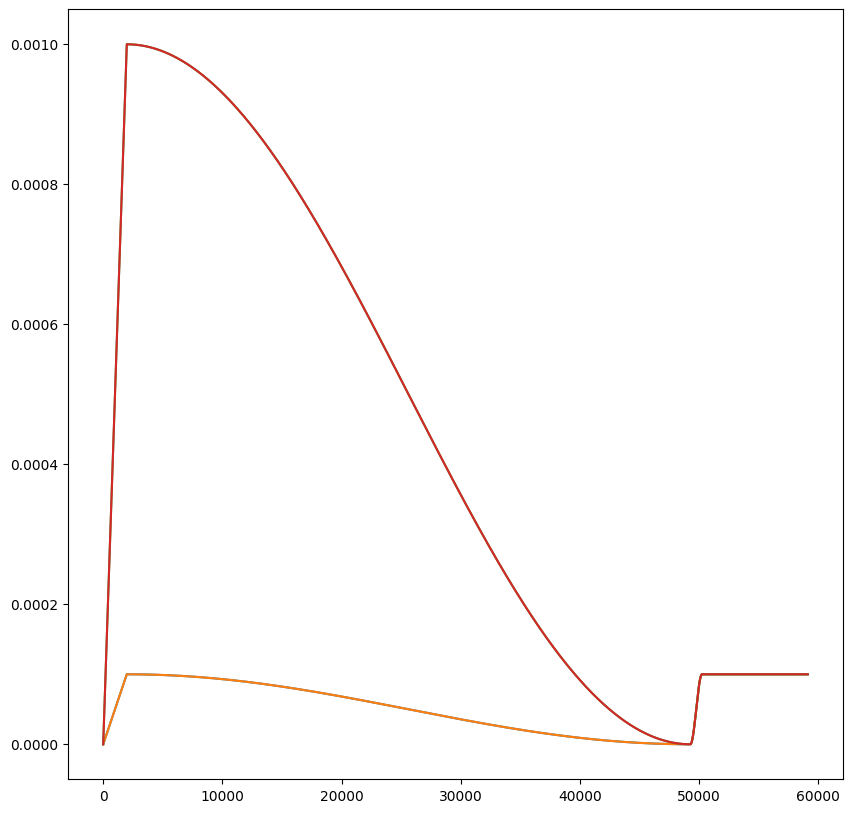

In [62]:
import matplotlib.pyplot as plt
plot_schedule(scheduler, int(config['n_effective_steps_per_epoch'] * config['n_epochs']))

#### Train & val

In [ ]:
train(model, optimizer, scheduler, train_loss, val_loss, train_loader, val_loader, config, **config)

wandb: Currently logged in as: kovanic. Use `wandb login --relogin` to force relogin


 11%|████████████▋                                                                                                     | 697/6250 [20:16<2:46:28,  1.80s/it]